In [1]:
import warnings
from pandas import Series
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import recall_score, precision_score, f1_score, log_loss
from sklearn.metrics import accuracy_score
import matplotlib
%matplotlib inline
warnings.filterwarnings("ignore")  # Убирает некритические сообщения
plt.style.use('ggplot')

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
RANDOM_SEED = 42

In [3]:
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', train.shape)
display(train.head(3))
print('Размерность тестового датасета: ', test.shape)
display(test.head(3))

Размерность тренировочного датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0


Размерность тестового датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y


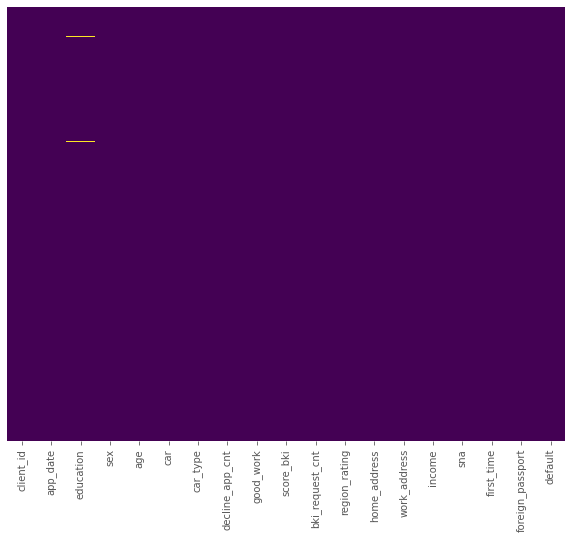

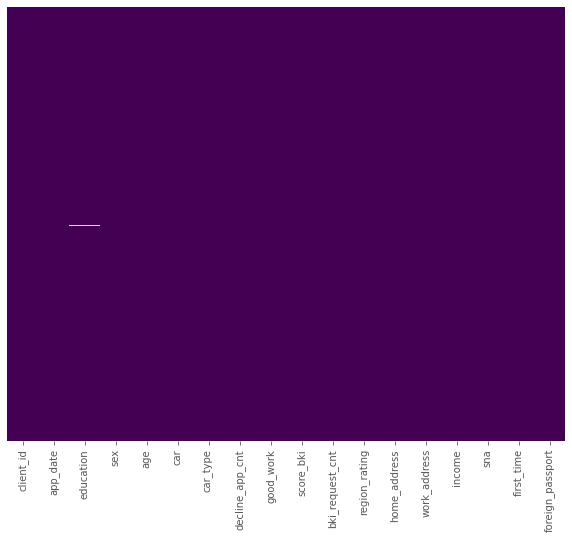

In [4]:
#Работа с пропусками
train.isnull().sum(), test.isnull().sum()
fig, ax = plt.subplots(figsize=(10, 8))
sns_heatmap = sns.heatmap(train.isnull(),
                          yticklabels=False,
                          cbar=False,
                          cmap='viridis')
fig, ax = plt.subplots(figsize=(10, 8))
sns_heatmap = sns.heatmap(
    test.isnull(), yticklabels=False, cbar=False, cmap='viridis')

<AxesSubplot:xlabel='education', ylabel='count'>

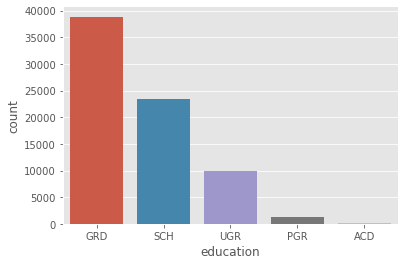

In [5]:
# посмотрим на распределение образования
sns.countplot(train['education'])
# видно, что большая часть заёмщиков имеет образование SCH
sns.countplot(test['education'])
# видно, что большая часть заёмщиков имеет образование SCH

In [6]:
# заполним пропуски наиболее частыми значениями

c_1 = collections.Counter(train['education'])
c_2 = collections.Counter(test['education'])

train['education'].fillna(c_1.most_common()[0][0], inplace=True)
test['education'].fillna(c_2.most_common()[0][0], inplace=True)
# проверим заполнение
train.isnull().sum(), test.isnull().sum()

(client_id           0
 app_date            0
 education           0
 sex                 0
 age                 0
 car                 0
 car_type            0
 decline_app_cnt     0
 good_work           0
 score_bki           0
 bki_request_cnt     0
 region_rating       0
 home_address        0
 work_address        0
 income              0
 sna                 0
 first_time          0
 foreign_passport    0
 default             0
 dtype: int64,
 client_id           0
 app_date            0
 education           0
 sex                 0
 age                 0
 car                 0
 car_type            0
 decline_app_cnt     0
 good_work           0
 score_bki           0
 bki_request_cnt     0
 region_rating       0
 home_address        0
 work_address        0
 income              0
 sna                 0
 first_time          0
 foreign_passport    0
 dtype: int64)

In [7]:
# Взглянем поближе на признак app_date
train.app_date.head(5), test.app_date.head(5)

(0    01FEB2014
 1    12MAR2014
 2    01FEB2014
 3    23JAN2014
 4    18APR2014
 Name: app_date, dtype: object,
 0    22MAR2014
 1    24JAN2014
 2    23MAR2014
 3    03FEB2014
 4    04FEB2014
 Name: app_date, dtype: object)

In [8]:
# Сконветируем в более удобный формат даты
train.app_date = pd.to_datetime(train.app_date)
test.app_date = pd.to_datetime(test.app_date)

In [9]:
# На основе признака app_date делаем новый признак
current_date = pd.to_datetime('24DEC2020')
# Количество дней, прошедших со дня подачи заявки
train['days'] = (current_date - train.app_date).dt.days
test['days'] = (current_date - test.app_date).dt.days

In [10]:
#Разделим колонки по типам данным для большего удобства работы и изучения
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'home_address', 'work_address', 
            'sna', 'first_time','region_rating']
num_cols = ['days', 'age', 'decline_app_cnt', 'score_bki', 
            'bki_request_cnt', 'income']

<AxesSubplot:xlabel='default', ylabel='count'>

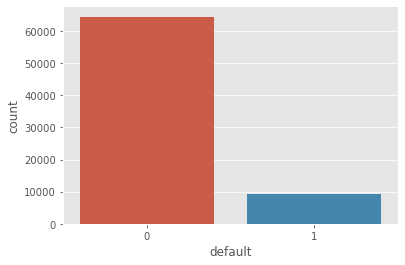

In [11]:
sns.countplot(train['default'])
#Распределение заёмщиков явно неравномерное, недефолтных клиентов заметно больше.

In [12]:
# попробуем oversampling для устранения дисбаланса
train_0 = train.query('default == 0')
train_1 = train.query('default == 1')
koeff = int(len(train_0)/len(train_1))
for i in range(koeff):
    train = train.append(train_1).reset_index(drop=True)  # объединяем
train['default'].value_counts()

1    65604
0    64427
Name: default, dtype: int64

<AxesSubplot:xlabel='default', ylabel='age'>

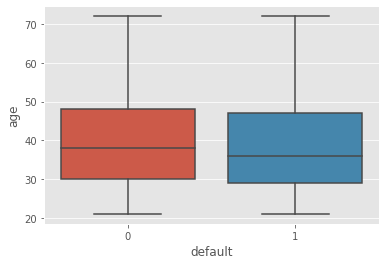

In [13]:
sns.boxplot(x=train.default, y=train.age)
# выбросов нет

#Недефолтные клиенты в среднем старше дефолтных. Выбросов нет.

<AxesSubplot:xlabel='default', ylabel='days'>

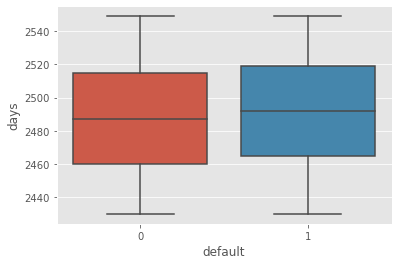

In [14]:
sns.boxplot(x=train.default, y=train.days)
#Со временем банк научился чаще выдавать кредиты, что очевидно повысило его прибыльность. Выбросов нет.

<AxesSubplot:xlabel='default', ylabel='decline_app_cnt'>

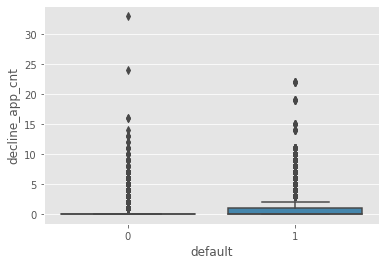

In [15]:
sns.boxplot(x=train.default, y=train.decline_app_cnt)

У дефолтных клиентов количество отклоненных заявок выше, чем у недефолтных. Есть выбросы, но удалять их нецелесообразно, т.к. медиана у нас равна практически 0 и весь этот признак обратится в 0. Но он может оказать влияние.

<AxesSubplot:xlabel='default', ylabel='score_bki'>

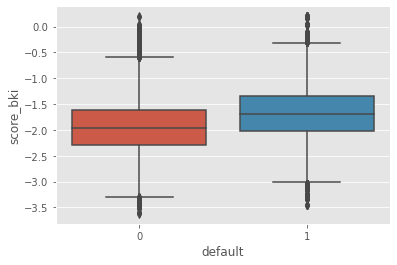

In [16]:
sns.boxplot(x=train.default, y=train.score_bki)

Средний скоринговый балл по данным из БКИ для тех, кому отказали - выше, чем для тех кому не отказали. Методика расчета этого показателя неизвестна (на сайте БКИ рейтинг от 300 до 850 баллов), возможно предположить, что чем ниже балл, тем надежнее заемщик. Если иначе, то есть над чем поработать в модели. Выбросы есть, надо убирать.

<AxesSubplot:xlabel='default', ylabel='bki_request_cnt'>

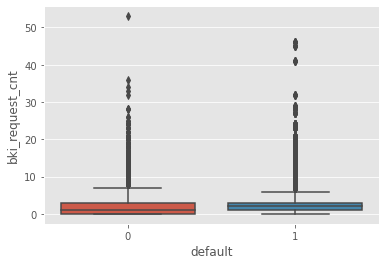

In [17]:
sns.boxplot(x=train.default, y=train.bki_request_cnt)

Средний показатель числа запросов в БКИ у дефолтных клиентов выше. Выбросы присутствуют.

<AxesSubplot:xlabel='default', ylabel='income'>

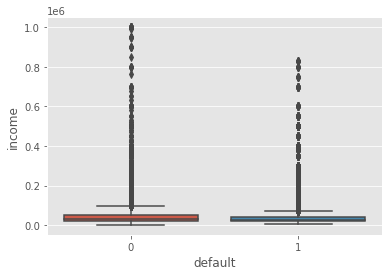

In [18]:
sns.boxplot(x=train.default, y=train.income)

Кредиты чаще выдают тем, у кого уровень дохода выше. Что вполне логично.Выбросы присутствуют.

In [19]:
# Функция определяет межквартильный интервал и возвращает 1.5 межквартильных расстояния с обеих
# сторон от этого интервала. С её помощью избавимся от выбросов.
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return lower_bound, upper_bound

In [20]:
# убираем выбросы в численных столбцах
num_cols_1 = ['bki_request_cnt', 'score_bki']
for colname in num_cols_1:
    d = outliers_iqr(train[colname])
    train = train.loc[train[colname].between(d[0], d[1])]

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123736 entries, 0 to 130030
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         123736 non-null  int64         
 1   app_date          123736 non-null  datetime64[ns]
 2   education         123736 non-null  object        
 3   sex               123736 non-null  object        
 4   age               123736 non-null  int64         
 5   car               123736 non-null  object        
 6   car_type          123736 non-null  object        
 7   decline_app_cnt   123736 non-null  int64         
 8   good_work         123736 non-null  int64         
 9   score_bki         123736 non-null  float64       
 10  bki_request_cnt   123736 non-null  int64         
 11  region_rating     123736 non-null  int64         
 12  home_address      123736 non-null  int64         
 13  work_address      123736 non-null  int64         
 14  inco

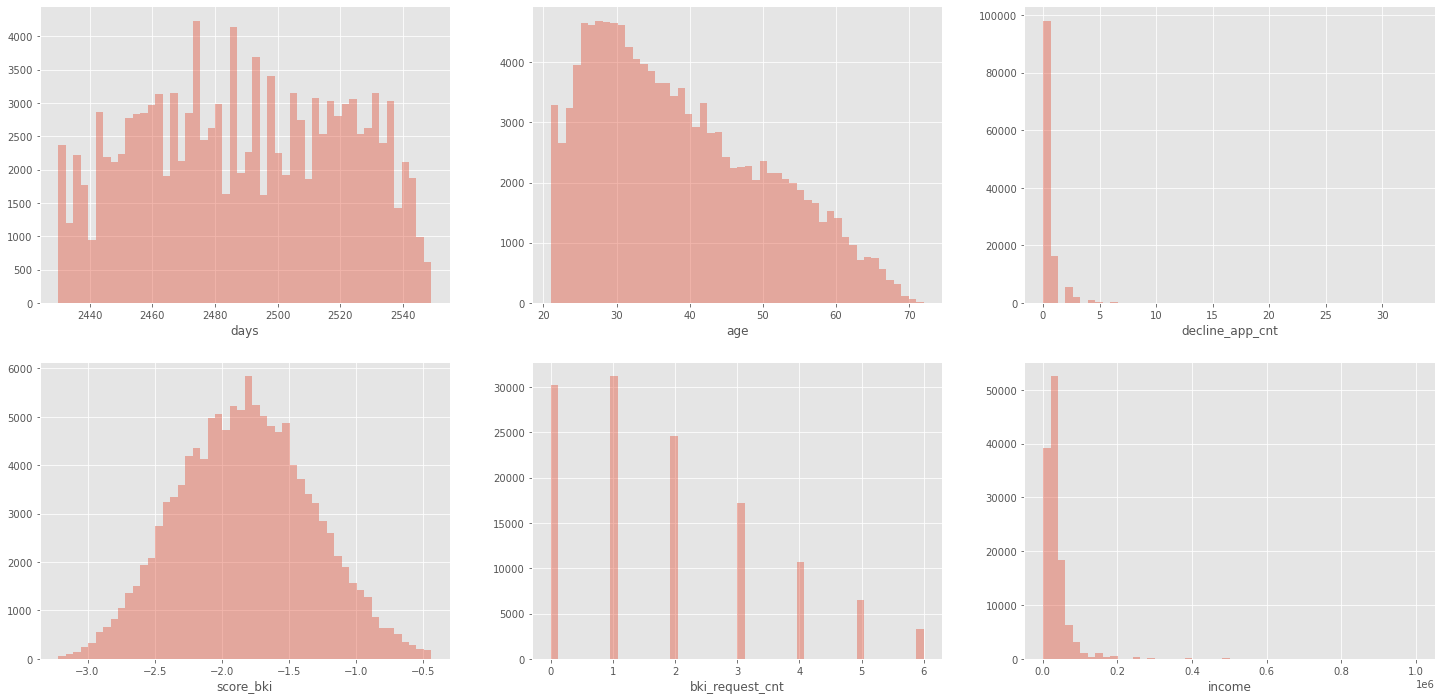

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(25, 12))
for col, i in zip(num_cols, range(7)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])

Прологарифмируем переменные, распределение которых смещено(2,3,5,6 графики)

In [23]:
num_cols_log = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
for i in num_cols_log:
    train[i] = np.log(train[i] + 1)

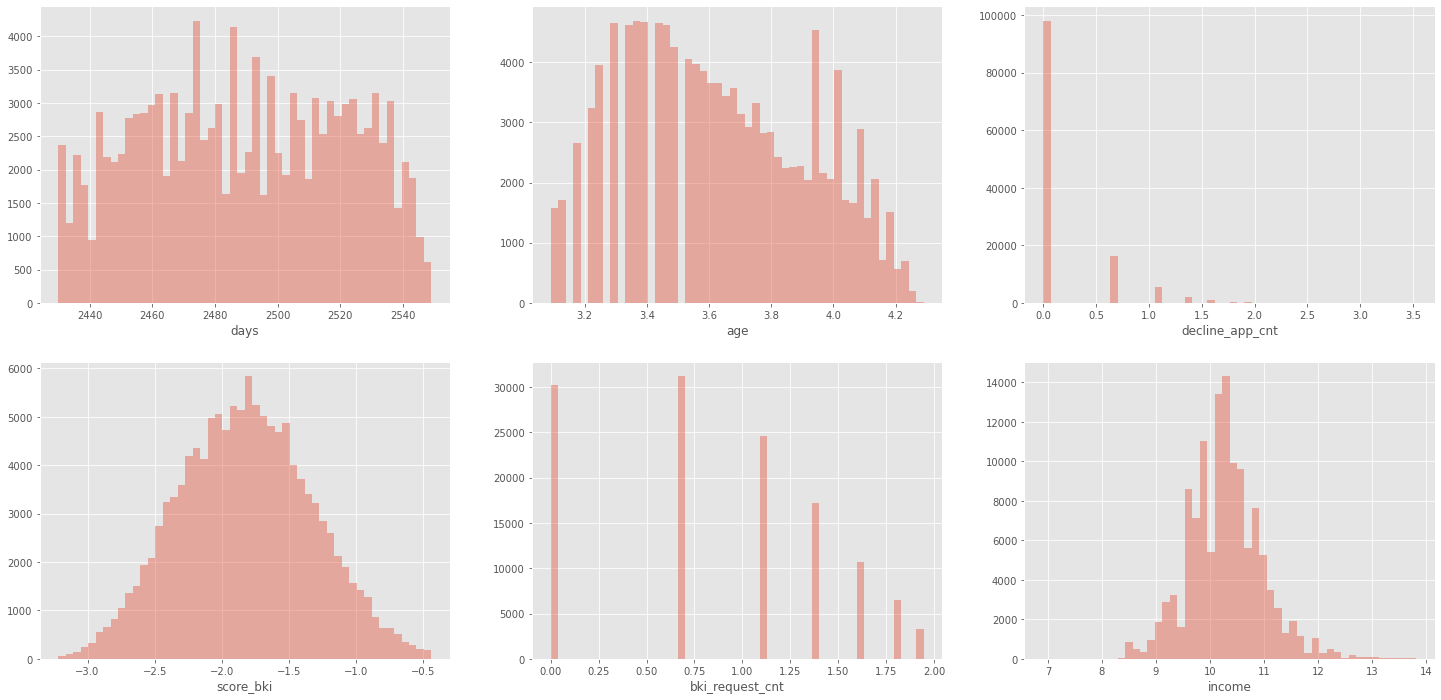

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(25, 12))
for col, i in zip(num_cols, range(7)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])

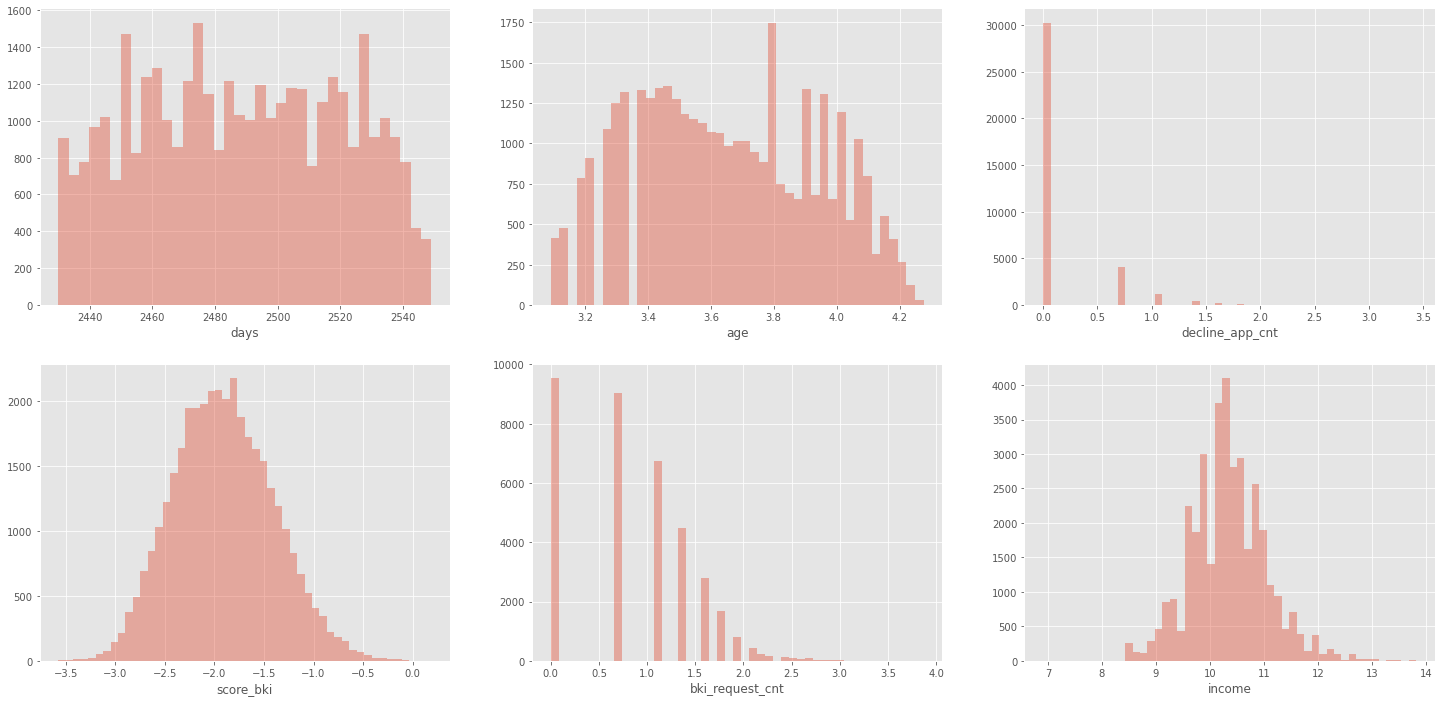

In [25]:
for i in num_cols_log:
    test[i] = np.log(test[i] + 1)
fig, axes = plt.subplots(2, 3, figsize=(25, 12))
for col, i in zip(num_cols, range(7)):
    sns.distplot(test[col], kde=False, ax=axes.flat[i])

Преобразуем бинарные переменные при помощи класса LabelEncoder

In [26]:
label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    test[column] = label_encoder.fit_transform(test[column])

In [27]:
corr = train[num_cols].corr()
corr.style.background_gradient(cmap='hot').set_precision(3)

,days,age,decline_app_cnt,score_bki,bki_request_cnt,income
days,1.000,-0.021,0.018,0.055,-0.006,-0.007
age,-0.021,1.000,-0.151,-0.109,0.047,-0.102
decline_app_cnt,0.018,-0.151,1.000,0.212,0.077,-0.023
score_bki,0.055,-0.109,0.212,1.000,0.108,-0.018
bki_request_cnt,-0.006,0.047,0.077,0.108,1.000,0.058
income,-0.007,-0.102,-0.023,-0.018,0.058,1.000


Высокой корреляции между признаками не наблюдается, 
за исключением искусственно созданного bki_age_rate и составляющих его признаков. 
Но корреляция не настолько высока (меньше 0.7), чтобы исключать наш признак из анализа.

In [28]:
train = pd.get_dummies(train, columns=['education'])
train = pd.get_dummies(train, columns=['region_rating'])
test = pd.get_dummies(test, columns=['education'])
test = pd.get_dummies(test, columns=['region_rating'])

In [29]:
cat_cols = [
    'home_address', 'work_address', 'sna', 'first_time', 'education_ACD',
    'education_GRD', 'education_PGR', 'education_SCH', 'education_UGR',
    'region_rating_20', 'region_rating_30', 'region_rating_40',
    'region_rating_50', 'region_rating_60', 'region_rating_70',
    'region_rating_80'
]
x_cat = OneHotEncoder(sparse=False).fit_transform(train[cat_cols].values)
y_cat = OneHotEncoder(sparse=False).fit_transform(test[cat_cols].values)

print(x_cat.shape)
print(y_cat.shape)

(123736, 38)
(36349, 38)


Text(0.5, 0, 'F-value')

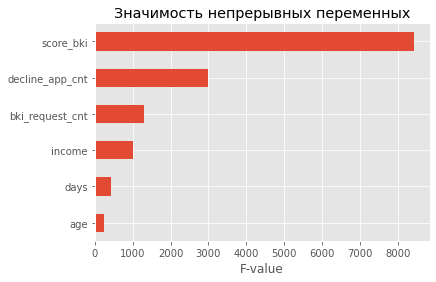

In [30]:
#Значимость непрерывных переменных
imp_num = Series(f_classif(train[num_cols], train['default'])[0],
                 index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')
plt.title('Значимость непрерывных переменных')
plt.xlabel('F-value')

Text(0.5, 1.0, 'Значимость бинарных переменных')

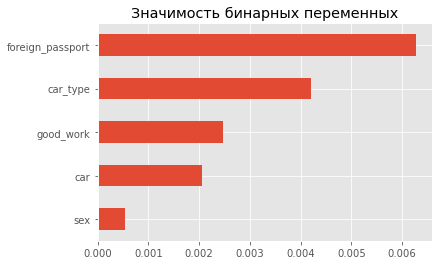

In [31]:
# Значимость бинарных признаков
imp_bin = Series(mutual_info_classif(train[bin_cols],
                                     train['default'],
                                     discrete_features=True),
                 index=bin_cols)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')
plt.title('Значимость бинарных переменных')

Text(0.5, 1.0, 'Significance of cat variables')

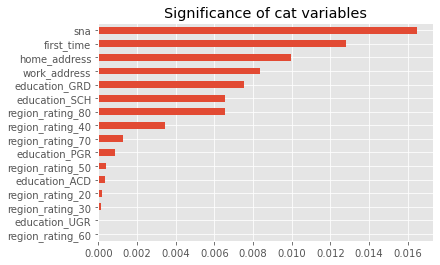

In [32]:
# Значимость категориальных признаков

imp_cat = pd.Series(mutual_info_classif(train[cat_cols],
                                        train['default'],
                                        discrete_features=True),
                    index=train[cat_cols].columns)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')
plt.title('Significance of cat variables')

Подготовка данных к машинному обучению

In [33]:
poly = PolynomialFeatures(2)

x_p = poly.fit_transform(train[num_cols].values)
y_p = poly.fit_transform(test[num_cols].values)

In [34]:
# Стандартизация числовых переменных

X_num = StandardScaler().fit_transform(x_p)
X_num.shape

(123736, 28)

In [35]:
Y_num = StandardScaler().fit_transform(y_p)
Y_num.shape

(36349, 28)

Объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

In [36]:
X = np.hstack([X_num, train[bin_cols].values, x_cat])
Y = train['default'].values

id_test = test['client_id']
test = np.hstack([Y_num, test[bin_cols].values, y_cat])

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.20,random_state=RANDOM_SEED,shuffle=True)

Подбор гиперпараметров (регуляризация)

In [38]:
# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучший penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучший penalty: l2
Лучшее C: 2.7825594022071245


Обучение и метрики

In [39]:
model = LogisticRegression(penalty='l2', C=2.7825594022071245, max_iter=800)
model.fit(X_train, y_train)

LogisticRegression(C=2.7825594022071245, max_iter=800)

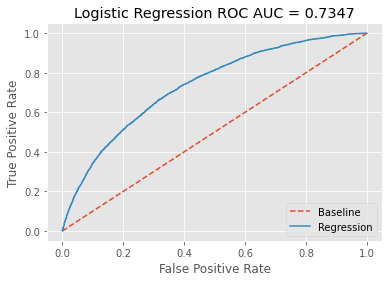

In [40]:
probs = model.predict_proba(X_test)
probs = probs[:, 1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

# Визуализация ROC AUC
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.4f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [41]:
# Функция выводит метрики accuracy и f1-score
def print_logisitc_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'acc = {acc:.2f} F1-score = {f1:.2f}')

In [42]:
Y_predicted = model.predict(X_test)
print_logisitc_metrics(y_test, Y_predicted)

acc = 0.67 F1-score = 0.67


<AxesSubplot:>

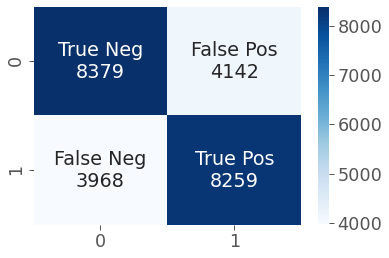

In [43]:
# confusion matrix
cm = confusion_matrix(y_test, Y_predicted)
# визуализация confusion matrix
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [44]:
model = LogisticRegression(penalty='l2', C=2.7825594022071245, max_iter=800)
model.fit(X, Y)
probs = model.predict_proba(test)
probs = probs[:, 1]

И в конце создаём экземпляр таблицы с предсказаниями, чтобы выложить соответствовать условию задания.

In [45]:
my_submission = pd.DataFrame({'client_id': id_test,
                              'default': probs})
my_submission.to_csv('submission.csv', index=False)

my_submission.head(10)

,client_id,default
0,74835,0.220509
1,17527,0.829741
2,75683,0.348720
3,26883,0.422825
4,28862,0.158737
5,99881,0.591557
6,26630,0.817538
7,79934,0.205402
8,16605,0.152182
9,105449,0.131753


Выводы
Существуют методы, улучшающие результаты работы модели за счёт оптимизации данных (нормализация, логарифмирование, регуляризация и другие), но основными факторами, позволяющими значительно улучшить эффективность предсказания, остаются EDA и feauture engineering.